In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2019) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,Conv2D,SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model

Using TensorFlow backend.


In [0]:
# https://keras.io/
!pip install -q keras
import keras

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k


# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

#Defining the dimensions
img_rows, img_cols, img_channels = train_features.shape[1],train_features.shape[2],train_features.shape[3] 


170500096/170498071 [==============================] - 6s 0us/step


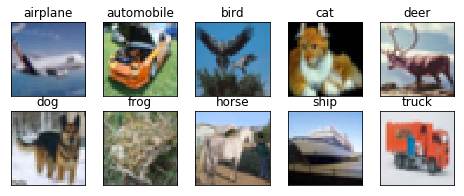

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)


In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
input = Input(shape=(img_rows,img_cols,img_channels))


#Layer 1
layer1 = Conv2D(32,(3,3),strides=(1,1),name='conv_1',border_mode='same',use_bias=False)(input)
layer1 = BatchNormalization(name='norm_1')(layer1)
layer1 = Activation('relu')(layer1)

#Layer 2
layer2 = Conv2D(32, (3,1), strides=(1,1),name='conv_2',border_mode='same', use_bias=False)(layer1)
layer2 = BatchNormalization(name='norm_2')(layer2)
layer2 = Activation('relu')(layer2)

# Layer 3
layer3 = Conv2D(32, (1,3), strides=(1,1),name='conv_3',border_mode='same', use_bias=False)(layer2)
layer3 = BatchNormalization(name='norm_3')(layer3)
layer3 = Activation('relu')(layer3)

#Maxpool
Maxpool1 = MaxPooling2D(pool_size=(2, 2))(layer3)

skip_connection = Maxpool1

# Layer 4
layer4 = SeparableConv2D(32, (3,3), strides=(1,1),name='conv_4',border_mode='same', use_bias=False)(Maxpool1)
layer4 = BatchNormalization(name='norm_4')(layer4)
layer4 = Activation('relu')(layer4)

# Layer 5
layer5 = Conv2D(32, (3,3), strides=(1,1),name='conv_5',border_mode='same', use_bias=False)(layer4)
layer5 = BatchNormalization(name='norm_5')(layer5)
layer5 = Activation('relu')(layer5)

#Maxpool
Maxpool2 = MaxPooling2D(pool_size=(2, 2))(layer5)

# Layer 6
layer6 = Conv2D(32, (5,5), strides=(1,1),name='conv_6', border_mode='same',use_bias=False)(layer5)
layer6 = BatchNormalization(name='norm_6')(layer6)
layer6 = Activation('relu')(layer6)

# Layer 7
layer7 = Conv2D(32, (3,3), strides=(1,1),name='conv_7',border_mode='same', use_bias=False, dilation_rate = 1)(layer6)
layer7 = BatchNormalization(name='norm_7')(layer7)
layer7 = Activation('relu')(layer7)

# Layer 8
layer8 = Conv2D(32, (3,3), strides=(1,1),name='conv_8',border_mode='same', use_bias=False,dilation_rate = 2)(layer7)
layer8 = BatchNormalization(name='norm_8')(layer8)
layer8 = Activation('relu')(layer8)

layer10 = Conv2D(10,(16,16),strides=(1,1),name='conv_9',use_bias=False)(layer8)
layer11 = Flatten()(layer10)

output = Activation('softmax')(layer11)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), name="conv_1", use_bias=False, padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), strides=(1, 1), name="conv_2", use_bias=False, padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 3), strides=(1, 1), name="conv_3", use_bias=False, padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), strides=(1, 1), name="conv_4", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_l

In [0]:
model = Model(inputs=[input],outputs=[output])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 32)        864       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 32, 32, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 32)        3072      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 32, 32, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
__________

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 21s 55ms/step - loss: 1.3848 - acc: 0.5092 - val_loss: 1.4728 - val_acc: 0.5336
Epoch 2/50
390/390 [==============================] - 17s 44ms/step - loss: 0.9619 - acc: 0.6612 - val_loss: 0.9969 - val_acc: 0.6522
Epoch 3/50
390/390 [==============================] - 17s 43ms/step - loss: 0.7983 - acc: 0.7188 - val_loss: 1.0304 - val_acc: 0.6607
Epoch 4/50
390/390 [==============================] - 17s 44ms/step - loss: 0.6821 - acc: 0.7617 - val_loss: 0.8453 - val_acc: 0.7072
Epoch 5/50
390/390 [==============================] - 17s 44ms/step - loss: 0.6003 - acc: 0.7890 - val_loss: 1.0108 - val_acc: 0.6684
Epoch 6/50
390/390 [==============================] - 17s 44ms/step - loss: 0.5276 - acc: 0.8143 - val_loss: 0.9373 - val_acc: 0.6964
Epoch 7/50
390/390 [==============================] - 17s 43ms/step - loss: 0.4667 - acc: 0.8364 - val_loss: 1.0305 - val_acc: 0.6935
Epoch 8/50
390/390 [==============================] - 17s 44ms

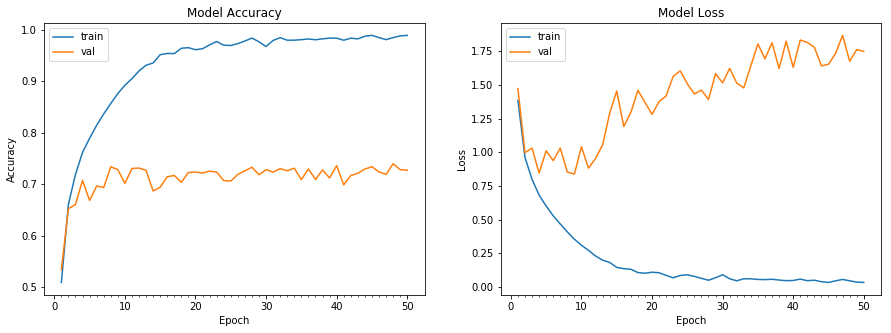

Accuracy on test data is: 72.70


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))